# Fashion-MNIST Classification

This project aims to build and compare different deep learning models for classifying images from the Fashion-MNIST dataset. I'm going to explore the impact of increasing model complexity, from a simple Artificial Neural Network (ANN) to more sophisticated Convolutional Neural Networks (CNNs), on performance and efficiency.

**Project Agenda & Steps:**

1.  **Dataset Setup:**
    *   Import necessary libraries.
    *   Load the Fashion-MNIST dataset.
    *   Preprocess the data (normalize and reshape images, one-hot encode labels).
    *   Verify the shapes of the processed data.

2.  **Model Building:**
    *   Define the architecture for each model:
        *   Basic ANN Model
        *   Basic CNN Model
        *   Deeper CNN Model

3.  **Model Training:**
    *   Train each model using the prepared training data.
    *   Implement Early Stopping and Model Checkpointing to optimize training and save the best model weights.

4.  **Model Evaluation:**
    *   Load the best weights for each trained model.
    *   Evaluate each model's performance on the test set using metrics like loss and accuracy.
    *   Visualize the training history (accuracy and loss curves) for comparison.
    *   Generate and visualize confusion matrices to understand model performance on each class.

5.  **Prediction Analysis:**
    *   Use the best performing model (Basic CNN in this case) to make predictions on the test set.
    *   Identify and visualize examples of both correctly and incorrectly classified images to gain insights into model behavior.

**Goal:** To analyze and demonstrate how model complexity influences classification accuracy and efficiency on the Fashion-MNIST dataset.

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tensorflow.keras import backend as K
K.clear_session()
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [5]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

#### 1. Load Dataset

Load the **Fashion-MNIST** dataset from Keras, splitting it into:  
- `train_images`, `train_labels` → training set  
- `test_images`, `test_labels` → test set  


In [30]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

#### 1.2. Normalize Data

Scale pixel values from **0–255** to the range **0–1** for faster and more stable training.  

**Example:**  
- Before: a pixel value could be `200`  
- After: `200 / 255 ≈ 0.78`  

In [31]:
train_images = train_images / 255
test_images = test_images / 255

#### 1.3. Reshape Data

Reshape images to **28×28×1** by adding a channel dimension, making them compatible with CNN layers.  

**Example:**  
- Before: `(60000, 28, 28)` → 60,000 grayscale images without channel info  
- After: `(60000, 28, 28, 1)` → channel dimension (`1`) added for CNN input  


In [32]:
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

In [33]:
test_images.shape

(10000, 28, 28, 1)

#### 1.4. One-Hot Encode Labels

Convert class labels (0–9) into **one-hot encoded vectors** with 10 output classes, required for multi-class classification.  

**Example:**  
- Original label: `3`  
- One-hot encoded: `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`  


In [34]:
train_labels_ohe = keras.utils.to_categorical(train_labels, num_classes=10)
test_labels_ohe = keras.utils.to_categorical(test_labels, num_classes=10)

#### 1.5. Verify Dataset Shapes

Print the shapes of images and labels after preprocessing to confirm everything is in the expected format.  

**Example output:**  
- Training images shape: `(60000, 28, 28, 1)`  
- Testing images shape: `(10000, 28, 28, 1)`  
- Training labels shape: `(60000, 10)`  
- Testing labels shape: `(10000, 10)`  


In [35]:
print("Training images shape:", train_images.shape)
print("Testing images shape:", test_images.shape)
print("Training labels shape:", train_labels_ohe.shape)
print("Testing labels shape:", test_labels_ohe.shape)

Training images shape: (60000, 28, 28, 1)
Testing images shape: (10000, 28, 28, 1)
Training labels shape: (60000, 10)
Testing labels shape: (10000, 10)


### 2. Model Building

#### 2.1 Basic ANN Model

- **Flatten (28×28→784)** → 0 params  
- **Dense (128, ReLU)** → 100,480 params  
- **Dense (64, ReLU)** → 8,256 params  
- **Dense (10, Softmax)** → 650 params  

**Total params:** ~109K  

In [36]:
ann_model = keras.Sequential([
  keras.layers.Input(shape=(28, 28, 1)),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(10, activation='softmax')
], name='mnist-fashion-model')

In [37]:
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
ann_model.summary()

Model: "mnist-fashion-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

#### 2.2 Basic CNN Model

- **Conv2D (32, 3×3) + MaxPool** → 320 params  
- **Conv2D (64, 3×3) + MaxPool** → 18,496 params  
- **Flatten**  
- **Dense (64, ReLU)** → 102,464 params  
- **Dense (10, Softmax)** → 650 params  

**Total params:** ~121K  

In [39]:
basic_cnn_model = keras.Sequential([
  keras.layers.Input(shape=(28, 28, 1)),
  keras.layers.Conv2D(32, (3, 3), activation='relu'),
  keras.layers.MaxPool2D((2, 2)),
  keras.layers.Conv2D(64, (3, 3), activation='relu'),
  keras.layers.MaxPooling2D((2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(10, activation='softmax')
], name='mnist-fashion-cnn-model')

basic_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
basic_cnn_model.summary()

Model: "mnist-fashion-cnn-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

#### 2.3 Deeper CNN Model

- **Conv2D (32, 3×3) + BN + MaxPool + Dropout** → 320 + 64 params  
- **Conv2D (64, 3×3) + BN + MaxPool + Dropout** → 18,496 + 128 params  
- **Conv2D (128, 3×3) + BN + MaxPool + Dropout** → 73,856 + 256 params  
- **Flatten**  
- **Dense (128, ReLU) + BN + Dropout** → 147,584 + 256 params  
- **Dense (10, Softmax)** → 1,290 params  

**Total params:** ~242K  

In [40]:
deeper_cnn_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(10, activation='softmax')
], name='mnist-fashion-deep-cnn-model')

deeper_cnn_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

deeper_cnn_model.summary()

e:\12.Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "mnist-fashion-deep-cnn-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,882 (437.04 KB)

 Trainable params: 111,178 (434.29 KB)

 Non-trainable params: 704 (2.75 KB)

### 3. Train models

#### 3.1 Training ANN Model

- **EarlyStopping**: monitors validation loss, stops if no improvement for 5 epochs, restores best weights.  
- **ModelCheckpoint**: saves best ANN weights (`best_ann_model_weights.weights.h5`) based on validation loss.  
- **Training**:  
  - Epochs: up to 30 (early stopping controls actual run)  
  - Batch size: 64  
  - Validation on test set  
  - Callbacks: EarlyStopping + ModelCheckpoint  

In [41]:
# early stop if the val_loss remains the same after 5 consecutive iterations
early_stopping = keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=5,
  restore_best_weights=True
)


model_checkpoint_ann = keras.callbacks.ModelCheckpoint(
  filepath='best_ann_model_weights.weights.h5',
  monitor='val_loss',
  save_best_only=True,
  save_weights_only=True,
  mode='min',
  verbose=1
)

In [42]:
print("Training ANN model...")
ann_history = ann_model.fit(
    train_images,
    train_labels_ohe,
    epochs=30,
    batch_size=64,
    validation_data=(test_images, test_labels_ohe),
    callbacks=[early_stopping, model_checkpoint_ann]
)
print("ANN model training finished.")

Training ANN model...
Epoch 1/30
907/938 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.7651 - loss: 0.6864
Epoch 1: val_loss improved from inf to 0.45176, saving model to best_ann_model_weights.weights.h5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7669 - loss: 0.6806 - val_accuracy: 0.8400 - val_loss: 0.4518
Epoch 2/30
899/938 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.8610 - loss: 0.3839
Epoch 2: val_loss improved from 0.45176 to 0.38518, saving model to best_ann_model_weights.weights.h5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - accuracy: 0.8611 - loss: 0.3835 - val_accuracy: 0.8616 - val_loss: 0.3852
Epoch 3/30
906/938 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.8777 - loss: 0.3373
Epoch 3: val_loss improved from 0.38518 to 0.36343, saving model to best_ann_model_weights.weights.h5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step - accuracy: 0.8777 - loss: 0.3373 - val_accuracy: 0.8715 - val_loss: 0.3634
Epoch 4/30
917/938 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - a

> The best validation loss so far is 0.33465 and  did not improve in time, infact it starts to increase after iteration 10

#### 3.2 Training Basic CNN Model

- **ModelCheckpoint**: saves best Basic CNN weights (`best_basic_cnn_model_weights.weights.h5`) based on validation loss.  
- **Training**:  
  - Epochs: up to 30 (early stopping controls actual run)  
  - Batch size: 64  
  - Validation on test set  
  - Callbacks: EarlyStopping + ModelCheckpoint

In [43]:
model_checkpoint_basic_cnn = keras.callbacks.ModelCheckpoint(
    filepath='best_basic_cnn_model_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

print("Training Basic CNN model...")
basic_cnn_history = basic_cnn_model.fit(
    train_images,
    train_labels_ohe,
    epochs=30,
    batch_size=64,
    validation_data=(test_images, test_labels_ohe),
    callbacks=[early_stopping, model_checkpoint_basic_cnn]
)
print("Basic CNN model training finished.")

Training Basic CNN model...
Epoch 1/30
926/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7373 - loss: 0.7282
Epoch 1: val_loss improved from inf to 0.37926, saving model to best_basic_cnn_model_weights.weights.h5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7384 - loss: 0.7251 - val_accuracy: 0.8674 - val_loss: 0.3793
Epoch 2/30
930/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8761 - loss: 0.3424
Epoch 2: val_loss improved from 0.37926 to 0.32824, saving model to best_basic_cnn_model_weights.weights.h5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8761 - loss: 0.3422 - val_accuracy: 0.8823 - val_loss: 0.3282
Epoch 3/30
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8940 - loss: 0.2897
Epoch 3: val_loss improved from 0.32824 to 0.31868, saving model to best_basic_cnn_model_weights.weights.h5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8940 - loss: 0.2897 - val_accuracy: 0.8859 - val_loss: 0.3187
Epoch 4/30
926/938 ━━━━━━━━━━━━━━━━━━━━ 0s 

#### 3.3 Training Deeper CNN Model

- **ModelCheckpoint**: saves best Deeper CNN weights (`best_deeper_cnn_model_weights.weights.h5`) based on validation loss.  
- **Training**:  
  - Epochs: up to 30 (early stopping controls actual run)  
  - Batch size: 64  
  - Validation on test set  
  - Callbacks: EarlyStopping + ModelCheckpoint  

In [ ]:
model_checkpoint_deeper_cnn = keras.callbacks.ModelCheckpoint(
    filepath='best_deeper_cnn_model_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

early_stopping2 = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


print("Training Deeper CNN model...")
deeper_cnn_history = deeper_cnn_model.fit(
    train_images,
    train_labels_ohe,
    epochs=30,
    batch_size=64,
    validation_data=(test_images, test_labels_ohe),
    callbacks=[early_stopping2, model_checkpoint_deeper_cnn]
)
print("Deeper CNN model training finished.")

Training Deeper CNN model...
Epoch 1/30
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8589 - loss: 0.3897
Epoch 1: val_loss improved from inf to 0.36684, saving model to best_deeper_cnn_model_weights.weights.h5
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8589 - loss: 0.3897 - val_accuracy: 0.8596 - val_loss: 0.3668
Epoch 2/30
934/938 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8645 - loss: 0.3746
Epoch 2: val_loss improved from 0.36684 to 0.34828, saving model to best_deeper_cnn_model_weights.weights.h5
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8645 - loss: 0.3746 - val_accuracy: 0.8674 - val_loss: 0.3483
Epoch 3/30
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8763 - loss: 0.3417
Epoch 3: val_loss improved from 0.34828 to 0.33009, saving model to best_deeper_cnn_model_weights.weights.h5
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8763 - loss: 0.3417 - val_accuracy: 0.8773 - val_loss: 0.3301
Epoch 4/30
937/938 ━━━━━━━━━━━━

### 4. Model Evaluation


#### 4.1 Model Evaluation Code Explanation

Load weights (ANN, Basic CNN, Deeper CNN) → Evaluate on test set → Get loss & accuracy → Print results

In [56]:
ann_model.load_weights('best_ann_model_weights.weights.h5')
basic_cnn_model.load_weights('best_basic_cnn_model_weights.weights.h5')
deeper_cnn_model.load_weights('best_deeper_cnn_model_weights.weights.h5')

loss_ann, accuracy_ann = ann_model.evaluate(test_images, test_labels_ohe, verbose=1)
loss_basic_cnn, accuracy_basic_cnn = basic_cnn_model.evaluate(test_images, test_labels_ohe, verbose=1)
loss_deeper_cnn, accuracy_deeper_cnn = deeper_cnn_model.evaluate(test_images, test_labels_ohe, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - accuracy: 0.8909 - loss: 0.3230
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9062 - loss: 0.2734
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9029 - loss: 0.2712


### Compare Plotting

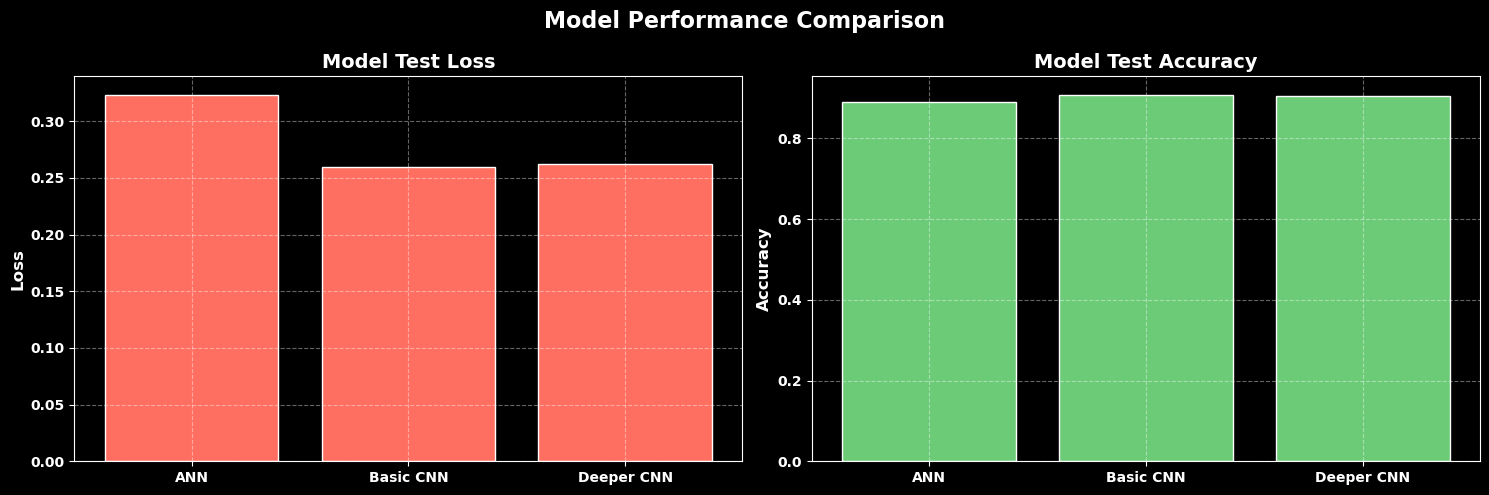

In [ ]:
models = ['ANN', 'Basic CNN', 'Deeper CNN']
losses = [loss_ann, loss_basic_cnn, loss_deeper_cnn]
accuracies = [accuracy_ann, accuracy_basic_cnn, accuracy_deeper_cnn]

plt.style.use("dark_background")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].bar(models, losses, color='#FF6F61', edgecolor='white')
axes[0].set_title('Model Test Loss', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.4)

# Accuracy plot
axes[1].bar(models, accuracies, color='#6BCB77', edgecolor='white')
axes[1].set_title('Model Test Accuracy', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.4)

plt.suptitle("Model Performance Comparison", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

#### 4.2 Model Evaluation (Confusion Matrix & Report)

- Predict test images (ANN, Basic CNN, Deeper CNN)  
- Convert one-hot labels to integers  
- Get predicted labels with `argmax`  
- Print confusion matrix & classification report for each model


In [ ]:
# indecies with true target values (1)
test_labels_ohe.argmax(axis=1)

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


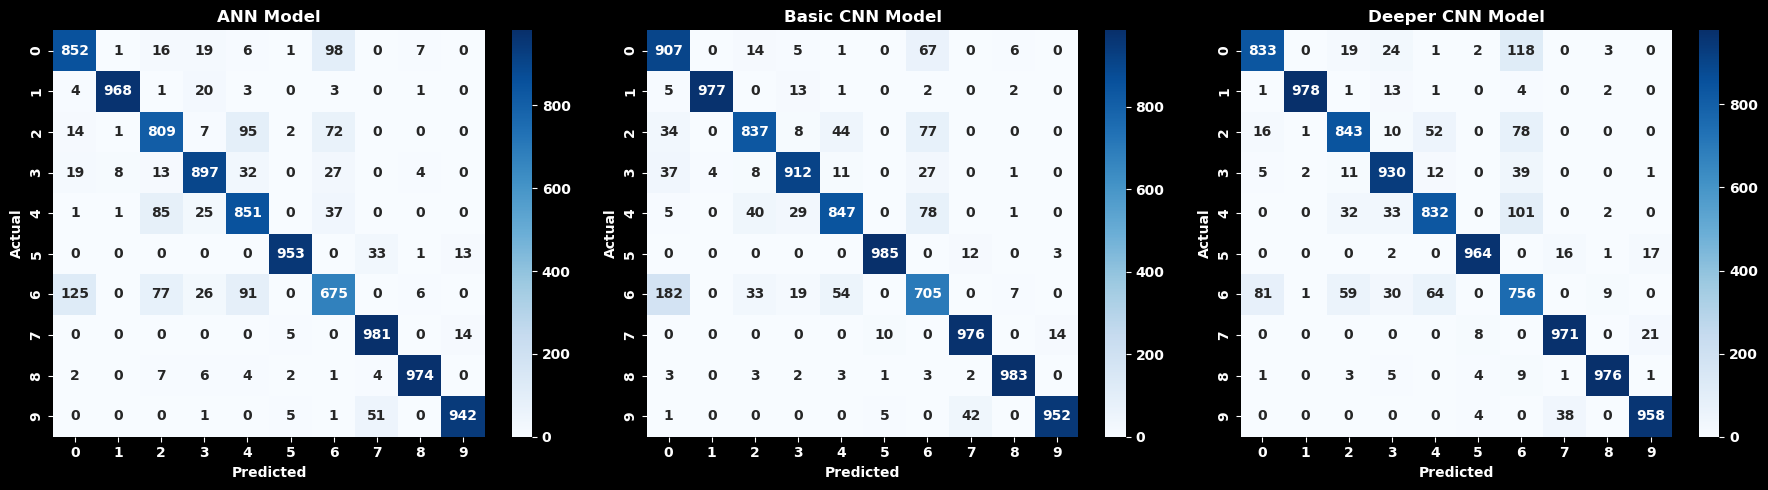

In [66]:
# Predictions
ann_predictions = ann_model.predict(test_images)
basic_cnn_predictions = basic_cnn_model.predict(test_images)
deeper_cnn_predictions = deeper_cnn_model.predict(test_images)

# Convert labels
test_labels_int = np.argmax(test_labels_ohe, axis=1)

ann_predicted_labels = np.argmax(ann_predictions, axis=1)
basic_cnn_predicted_labels = np.argmax(basic_cnn_predictions, axis=1)
deeper_cnn_predicted_labels = np.argmax(deeper_cnn_predictions, axis=1)

# Confusion matrices
cm_ann = confusion_matrix(test_labels_int, ann_predicted_labels)
cm_basic = confusion_matrix(test_labels_int, basic_cnn_predicted_labels)
cm_deeper = confusion_matrix(test_labels_int, deeper_cnn_predicted_labels)

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_ann, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("ANN Model")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_basic, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Basic CNN Model")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

sns.heatmap(cm_deeper, annot=True, fmt="d", cmap="Blues", ax=axes[2])
axes[2].set_title("Deeper CNN Model")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [92]:
wrong_predictions = 10_000 - (ann_predicted_labels == test_labels_int).sum()
round((wrong_predictions / 10_000) * 100, 2)
# 10.98% wrong predictions

10.98

#### 4.3 Model Comparison

- Created a dataframe to store **test loss** and **test accuracy** for ANN, Basic CNN, and Deeper CNN.  
- Plotted training history for each model (accuracy & loss vs. epochs).  
- Helps compare how models learn and generalize over time.  

In [ ]:
models = {
    "ANN": ("cyan", ann_history),
    "Basic CNN": ("magenta", basic_cnn_history),
    "Deeper CNN": ("yellow", deeper_cnn_history)
}

performance_data = {
    'Model': ['ANN', 'Basic CNN', 'Deeper CNN'],
    'Test Loss': [loss_ann, loss_basic_cnn, loss_deeper_cnn],
    'Test Accuracy': [accuracy_ann, accuracy_basic_cnn, accuracy_deeper_cnn]
}

performance_df = pd.DataFrame(performance_data)


fig = make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))


for name, (color, history) in models.items():
    # Accuracy
    fig.add_trace(go.Scatter(y=history.history['accuracy'], mode='lines',
                             name=name, line=dict(color=color, dash='solid'), hovertemplate='Epoch: %{x}<br>Accuracy: %{y:.4f}<extra></extra>'), row=1, col=1)
    fig.add_trace(go.Scatter( y=history.history['val_accuracy'], mode='lines',
                             name=name, line=dict(color=color, dash='dot'), showlegend=False, hovertemplate='Epoch: %{x}<br>Loss: %{y:.4f}<extra></extra>'), row=1, col=1)

    # Loss
    fig.add_trace(go.Scatter(y=history.history['loss'], mode='lines',
                             name=name, line=dict(color=color, dash='solid'), hovertemplate='Epoch: %{x}<br>Accuracy: %{y:.4f}<extra></extra>'), row=1, col=2)
    fig.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines',
                             name=name, line=dict(color=color, dash='dot'), showlegend=False, hovertemplate='Epoch: %{x}<br>Loss: %{y:.4f}<extra></extra>'), row=1, col=2)
    fig.update_xaxes(title_text="Epoch")
    fig.update_xaxes(tickvals=list(range(0, 30, 5)))
    
    
fig.update_layout(
    title_text="Model Comparison: Accuracy & Loss (Train=Solid, Val=Dot)",
    height=500,
    width=1400,
    template="plotly_dark"
)

fig.show()

#### Checking if the train and test labels are evenly distributed (better late, than never), making sure the model is not biased and the test accuracy is reliable

In [151]:
test_labels.shape, train_labels.shape

((10000,), (60000,))

In [152]:
pd.DataFrame(train_labels).value_counts()

0
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

In [149]:
pd.DataFrame(test_labels).value_counts()

0
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: count, dtype: int64

#### 4.4 Predictions

This code:
- Uses the trained **Basic CNN model** to predict on test images.  
- Identifies **correctly** and **incorrectly** classified samples.  
- Randomly selects 100 correct and 100 incorrect predictions.  
- Displays them in a **20×10 grid**:  
  - ✅ Correct predictions → **Green title** (only predicted label).  
  - ❌ Incorrect predictions → **Red title** (Predicted vs True label).  

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


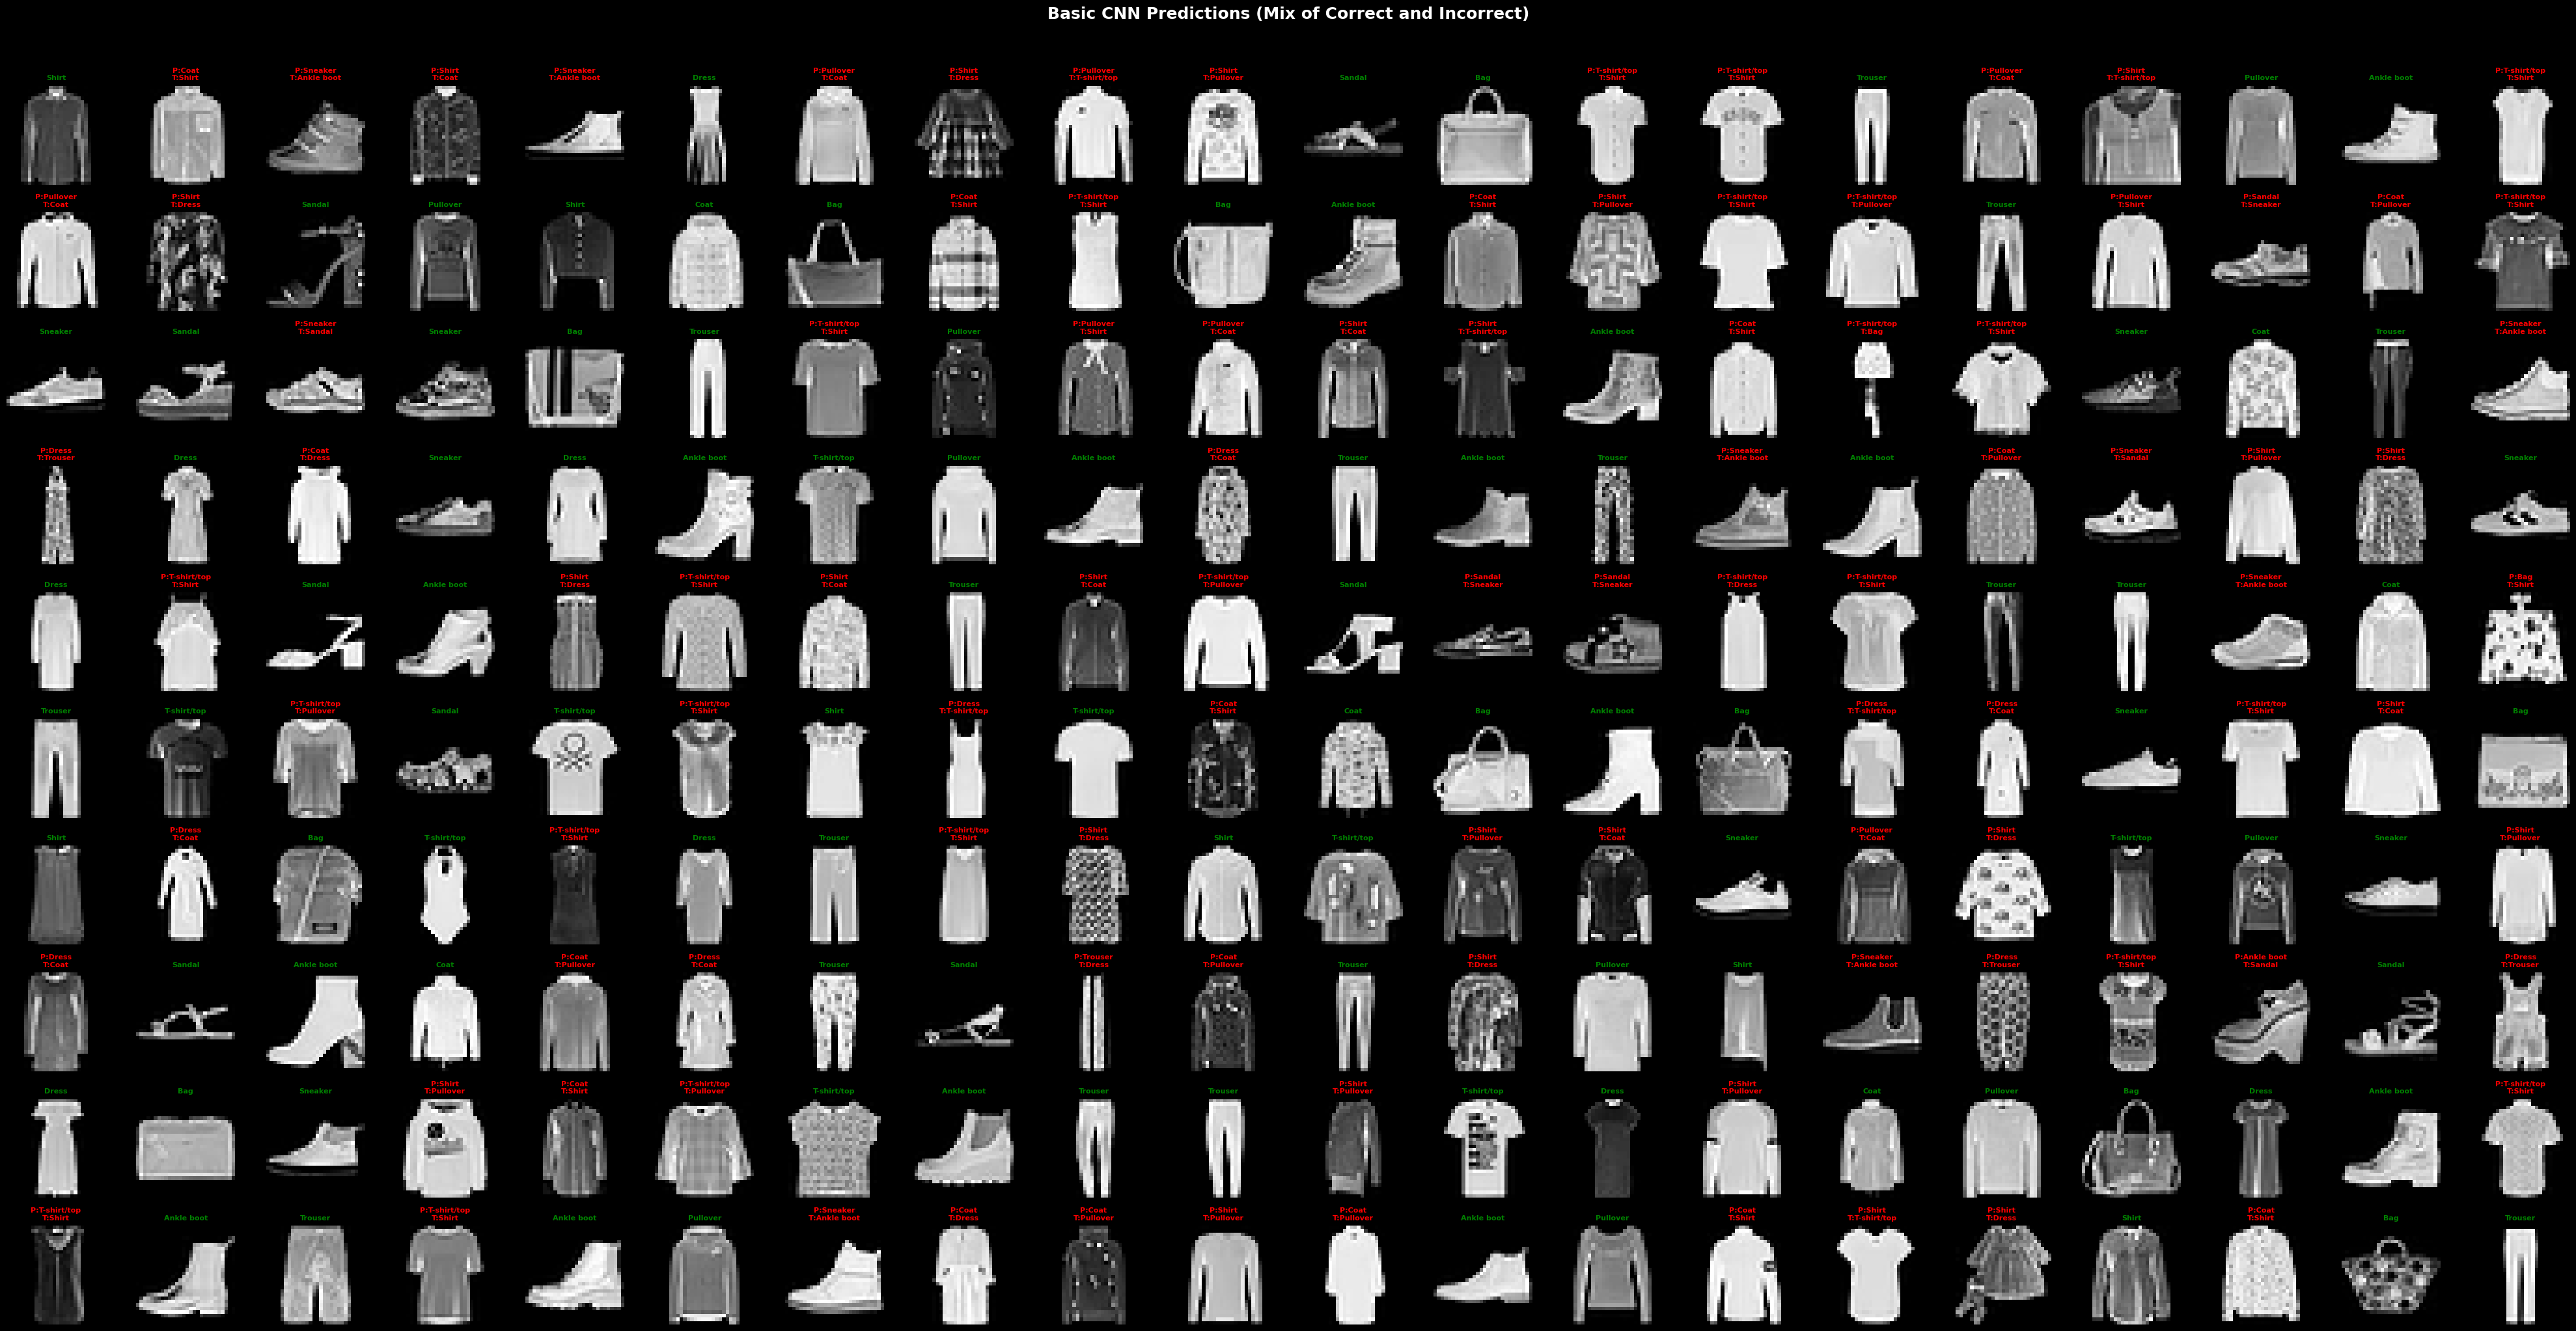

In [ ]:
basic_cnn_predictions = basic_cnn_model.predict(test_images)
basic_cnn_predicted_labels = np.argmax(basic_cnn_predictions, axis=1)

# Find correctly and incorrectly classified images
correctly_classified_indices = np.where(basic_cnn_predicted_labels == test_labels)[0]  # this returns vecrot (10000,) and with (10000,)[0] we get just the array with 10000 numbers
incorrectly_classified_indices = np.where(basic_cnn_predicted_labels != test_labels)[0]

# Define class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Select a mix of correctly and incorrectly classified images
num_correct_to_show = 100
num_incorrect_to_show = 100

# Ensure we don't try to show more images than available
num_correct_to_show = min(num_correct_to_show, len(correctly_classified_indices))
num_incorrect_to_show = min(num_incorrect_to_show, len(incorrectly_classified_indices))

selected_correct_indices = np.random.choice(correctly_classified_indices, num_correct_to_show, replace=False)
selected_incorrect_indices = np.random.choice(incorrectly_classified_indices, num_incorrect_to_show, replace=False)

# Combine and shuffle the indices
all_indices = np.concatenate((selected_correct_indices, selected_incorrect_indices))
np.random.shuffle(all_indices)

# Display images in a 20x10 grid
num_cols = 20
num_rows = 10
num_images_to_show = num_correct_to_show + num_incorrect_to_show

fig, axes = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))
fig.suptitle("Basic CNN Predictions (Mix of Correct and Incorrect)",fontsize=18, y=1.02)

for i, idx in enumerate(all_indices[:num_images_to_show]):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(test_images[idx].reshape(28, 28), cmap='gray')

    pred = class_names[basic_cnn_predicted_labels[idx]]
    true = class_names[test_labels[idx]]

    if basic_cnn_predicted_labels[idx] == test_labels[idx]:
        color = "green"
        title = f"{pred}"
    else:
        color = "red"
        title = f"P:{pred}\nT:{true}"

    axes[row, col].set_title(title, fontsize=8, color=color)
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

> Note: This is a sample of 200 (100 correct predictions and 100 wrong predictions) images out of 10000